In [5]:
import pandas as pd
import numpy as np
from math import ceil
import time
import glob,os
import re
import matplotlib.pyplot as plt
import pickle
import pdb

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler


Using TensorFlow backend.


In [6]:
DesignID=pd.read_csv('OptDesign.csv',sep=',',header=1)            #experiment design codes for adults




DesignID=pd.get_dummies(data=DesignID,columns=['Full Braking Before Impact','Weather','Road Type','Day or Night'])


DesignID=DesignID.drop(columns=['Unnamed: 0'],axis=1)


def scantext():                                                       #text files of VR data
    x=[]
    for path,dirs,files in os.walk('/home/arash/VRdata/Data/'):
        for f in files:
            if f.endswith('.txt'):
                x.append(os.path.join(path,f))
    return(x)



alltext=scantext()
        

In [7]:
googleforms=pd.read_csv('/home/arash/VRdata/Google Forms/PED-AV Questionnaire.csv',sep=',',header=0)

googleforms=pd.get_dummies(data=googleforms,columns=['Age','Gender','Occupation','Education','driving license','mode',
                                                     'workwalk','shopwalk','Vrexp','Heart','vision','anxiety', 'Headaches','dizziness'])

googleforms=googleforms.drop(columns=['Gender_Male','driving license_No','Vrexp_No','numwalk','Education_kid'],axis=1)            #numwalk is not reported in a readible form so i remove it temporarly

googleforms=googleforms.rename(columns={'Age_12-Sep':'Age_9-12',
                            'Age_15-Dec':'Age_12-15'
                           })

In [8]:
experiments=[]
for filename in alltext:
    lastslashindex=filename.rfind('/')
    onetolastslashindex=filename[:lastslashindex].rfind('/')
    name=filename[onetolastslashindex+1:lastslashindex]                         #name of the participant
    hyphen=filename[lastslashindex:].find('-')
    desID=int(filename[lastslashindex+1:][:hyphen-1])                             #scenario ID
    df=pd.read_csv(filename,header=None,names=['status','y','height','x',4,5,'o1','o2','o3','timeelaspsed','timehr','timemin','timesec'],sep=':|;|,|\(|\)',engine='python')   #x,y,height: coordinates,     #o1,o2,o3: head orientation
    df=df.drop(columns=[4,5],axis=1)
    

    df['scenario']=desID
    df['name']=name
    df['filename']=filename[24:]
    tindex=(df.index[df['status']=='u ']-1).tolist()
    pindex=(df.index[df['status']=='u ']).tolist()
    df.iloc[pindex,df.columns.get_loc('timeelaspsed')]=df.iloc[tindex,0].values
    df.iloc[pindex,df.columns.get_loc('timehr')]=df.iloc[tindex,1].values
    df.iloc[pindex,df.columns.get_loc('timemin')]=df.iloc[tindex,2].values
    df.iloc[pindex,df.columns.get_loc('timesec')]=df.iloc[tindex,3].values
    df=df.drop(df.index[tindex])
    df=df.reset_index()
    df=df.drop('index',axis=1)
    
    
    
    experiments.append(df)
    
#Row1: u: user, L: car on the bottom lane   R:Car on top lane, NaN: different points of cars     
#columns: y:axis parallel to street, increases in the left side of user, x: axix Perpendicular to street, dicreases when user crosses the road

In [9]:
ALLDATA=pd.DataFrame(index=range(len(experiments)),columns=['File','Scenario','Wait Time (s)','PET (s)', 
       'Distace to Collision Point','Card ID', 'Speed Limit', 'Lane Width', 'Minimum Gap',
       'Mean Arrival Rate', 'AV', 'Full Braking Before Impact_-1.0',
       'Full Braking Before Impact_1', 'Full Braking Before Impact_2',
       'Full Braking Before Impact_3', 'Clear', 'Snowy',
       'One way', 'two way',
       'Two way with median', 'Day','Night','name', 'numcars', 'Vrexpnum', 'Age_9-12', 'Age_15-18', 'Age_12-15',
       'Age_18 - 24', 'Age_25 - 29', 'Age_30 - 39', 'Age_40 - 49',
       'Age_50 - 59', 'Age_60+', 'Gender_Female', 'Occupation_Employed',
       'Occupation_Student', 'Occupation_Unemployed', 'Occupation_kid',
       'Education_Bachelors degree', 'Education_College/University student',
       'Education_Doctorate degree', 'Education_High school diploma',
       'Education_Masters degree', 'Education_Professional degree',
       'driving license_Yes', 'mode_Bike', 'mode_Car', 'mode_Public Transit',
       'mode_Walking', 'workwalk_No', 'workwalk_Sometimes', 'workwalk_Yes',
       'shopwalk_No', 'shopwalk_Sometimes', 'shopwalk_Yes', 'shopwalk_kid',
       'Vrexp_Yes', 'Heart_Currently', 'Heart_Over the years',
       'vision_Currently', 'vision_Over the years', 'anxiety_Currently',
       'anxiety_Over the years', 'Headaches_Currently',
       'Headaches_Over the years', 'dizziness_Over the years','starttime'])

In [10]:
for n in range(len(experiments)):
    if not 1<= experiments[n]['scenario'][0] <87:         #check if the scenario is valid
        ALLDATA.iloc[n,0]=experiments[n]['filename'][0]
        ALLDATA.iloc[n,1]='Err3'
        ALLDATA.iloc[n,2]='Err3'                     #error 3: scenario is not valid
        ALLDATA.iloc[n,3]='Err3'
        ALLDATA.iloc[n,4]='Err3'
        ALLDATA.iloc[n,5:22]='Err3'
        ALLDATA.iloc[n,22:67]='Err3'
        ALLDATA.iloc[n,67]='Err3'

        continue
    
    pindex=(experiments[n].index[experiments[n]['status']=='u ']).tolist()     #indces of pedestrians in the experiment dataset

    for index, item in enumerate(pindex):                                      #adding time to all u, L, R and NaN rows
        if index>1:
            experiments[n].iloc[pindex[index-1]:pindex[index],7]=experiments[n].iloc[pindex[index-1],7]
    experiments[n].iloc[max(pindex):,7]=experiments[n].iloc[max(pindex),7]        


    #wait time calculation
    if len(experiments[n]['status'][experiments[n]['status']=='L0 '])>0:                    #to check if first car appears at all
        firstcarL=experiments[n]['status'][experiments[n]['status']=='L0 '].index[0]    #index of first car on L lane
    else:
        firstcarL=99999999
    if len(experiments[n]['status'][experiments[n]['status']=='R0 '])>0:
        firstcarR=experiments[n]['status'][experiments[n]['status']=='R0 '].index[0]    #index of first car on R lane
    else:
        firstcarR=99999999
    firstcar=min(firstcarL,firstcarR)                                               #index of first car appearing
    if firstcar<99999998:
        firstcarappeartime=float(experiments[n].iloc[firstcar,7])                     #time of first car appearing
        firstcarname=(experiments[n].iloc[firstcar,0])                                #is the fisrt car L0 or R0
        firstcary0=experiments[n].iloc[firstcar,1]                                      #y of first car
            

        if firstcary0>experiments[n].iloc[0,1]:                                 #to determine direction of first car
            if experiments[n][experiments[n]['status']==firstcarname][experiments[n]['y']<experiments[n].iloc[0,1]].shape[0]>0:                   #to check if user has waited for the 1st car to pass
                firstcartime=float(experiments[n].iloc[experiments[n][experiments[n]['status']==firstcarname][experiments[n]['y']<experiments[n].iloc[0,1]].index[0]-1,7])    #time first car passes the pedestrian, users are only allowed to start crossing after first car passed
                firstcarindex=[experiments[n][experiments[n]['status']==firstcarname][experiments[n]['y']<experiments[n].iloc[0,1]].index[0]]
            else:
                firstcartime=99999999
        else:
            if experiments[n][experiments[n]['status']==firstcarname][experiments[n]['y']>experiments[n].iloc[0,1]].shape[0]>0:
                firstcartime=float(experiments[n].iloc[experiments[n][experiments[n]['status']==firstcarname][experiments[n]['y']>experiments[n].iloc[0,1]].index[0]-1,7])
                firstcarindex=[experiments[n][experiments[n]['status']==firstcarname][experiments[n]['y']>experiments[n].iloc[0,1]].index[0]]
            else:
                firstcartime=99999999
                    

 
        if firstcartime<99999998:
            pedafter1st=[i for i in pindex if i >= (firstcarindex[0])-1]                      #indices of pedestrians after 1st car passed
            lastpedbefore1st=[i for i in pindex if i < (firstcarindex[0])-1]
            #lastpedbefore1st=lastpedbefore1st[len(lastpedbefore1st)-1]                       
            if experiments[n].iloc[pedafter1st][pd.to_numeric(experiments[n]['x'])<(float(experiments[n]['x'][0])-0.2)].shape[0]==0:
                ALLDATA.iloc[n,0]=experiments[n]['filename'][0]
                ALLDATA.iloc[n,1]='Err4'
                ALLDATA.iloc[n,2]='Err4'                     #error 4: user does not start crossing
                ALLDATA.iloc[n,3]='Err4'
                ALLDATA.iloc[n,4]='Err4'
                ALLDATA.iloc[n,5:22]='Err4' #ALLDATA.loc[n,5:22]=='Err4'#DesignID[DesignID['Card ID']==experiments[n]['scenario'][0]].iloc[0,:].values                      
                ALLDATA.iloc[n,22:67]='Err4'
                ALLDATA.iloc[n,67]='Err4'
                continue
            else:
                pedstartmovetime=float(experiments[n].iloc[pedafter1st][pd.to_numeric(experiments[n]['x'])<(float(experiments[n]['x'][0])-0.2)]['timeelaspsed'].tolist()[0])    #time when pedestrian has started walking, measured as the point that the distance from starting point exceeds 0.2 m
                pedstartmoveindex=experiments[n].iloc[pedafter1st][pd.to_numeric(experiments[n]['x'])<(float(experiments[n]['x'][0])-0.2)].index[0]

                waittime=pedstartmovetime-firstcartime                          

            #PET calculation
                if 'ACCIDENT' in set(experiments[n]['status']):
                    pet=0
                    distance=1000
                else:
                    if firstcarL==99999999:
                        pet=0
                        distance=1000
                    else:

                        if experiments[n].iloc[pindex][pd.to_numeric(experiments[n]['x'])<(float(experiments[n]['x'][firstcarL+1]))].shape[0]==0:
                            ALLDATA.iloc[n,0]=experiments[n]['filename'][0]
                            ALLDATA.iloc[n,1]=experiments[n]['scenario'][0]
                            ALLDATA.iloc[n,2]= waittime                     #error 5: user does not finish crossing 1st lane
                            ALLDATA.iloc[n,3]='Err5'
                            ALLDATA.iloc[n,4]='Err5'
                            ALLDATA.iloc[n,67]=pedstartmovetime
                        else:   
                            pedpassLtime=float(experiments[n].iloc[pindex][pd.to_numeric(experiments[n]['x'])<(float(experiments[n]['x'][firstcarL+1]))]['timeelaspsed'].tolist()[0])        #time pedestrian passes potential accident location, only L lane is considered as pedestrians do not cross R lane completly
                            pedpassLindex=experiments[n].iloc[pindex][pd.to_numeric(experiments[n]['x'])<(float(experiments[n]['x'][firstcarL+1]))].index[0:2]                               #index of when the user passes potential accident location, only L lane is considered as pede
                            PETpassyloc=experiments[n].iloc[pedpassLindex[0],1]
                            if len(pedpassLindex) <2:
                                atpedpassdata=experiments[n].iloc[pedpassLindex[0]:,:]
                            else:
                                atpedpassdata=experiments[n].iloc[pedpassLindex[0]:pedpassLindex[1],:]     #data from the scene that user has crossed the PET point, includes cars that were in the scene at the time

                            CarLindex=experiments[n][experiments[n]['status'].str.contains('L',na=False)].index
                            afterpedmoveCarLindex=[i for i in CarLindex if i > pedstartmoveindex]
                            afterpedmoveCarLy=experiments[n].iloc[afterpedmoveCarLindex]['y']
                            firstcarLy0=experiments[n].iloc[firstcarL,1]
                            if firstcarLy0<experiments[n].iloc[0,1]:     #if L lane is directed right to left, ie one way scenarios
                                possiblePetCarY=afterpedmoveCarLy[(afterpedmoveCarLy<experiments[n].iloc[0,1]) & (afterpedmoveCarLy>(experiments[n].iloc[0,1]-1))]      #cars on L lane that has passed a hypothetical one meter strip before pedestrian starting point, after pedestrian has crossed
                                CarsbeforePedinscene=atpedpassdata[atpedpassdata['status'].str.contains('L',na=False)][atpedpassdata['y']<PETpassyloc]


                                if CarsbeforePedinscene.shape[0]==0:
                                    distance=1000
                                else:
                                    CarbeforePedindex=CarsbeforePedinscene.index[0]
                                    CarbeforePedinsceneFront=experiments[n].iloc[CarbeforePedindex+3,1]
                                    distance=abs(CarbeforePedinsceneFront-PETpassyloc)

                                if possiblePetCarY.empty:
                                    pet=1000
                                else:
                                    PetCarindex=possiblePetCarY.index[0]
                                    vehLpasstime=float(experiments[n].iloc[PetCarindex,7])
                                    pet=vehLpasstime-pedpassLtime
                            else:    # two way scenarios
                                possiblePetCarY=afterpedmoveCarLy[(afterpedmoveCarLy>experiments[n].iloc[0,1]) & (afterpedmoveCarLy<(experiments[n].iloc[0,1]+1))]
                                CarsbeforePedinscene=atpedpassdata[atpedpassdata['status'].str.contains('L',na=False)][atpedpassdata['y']>PETpassyloc]


                                if CarsbeforePedinscene.shape[0]==0:
                                    distance=1000
                                else:
                                    CarbeforePedindex=CarsbeforePedinscene.index[0]
                                    CarbeforePedinsceneFront=experiments[n].iloc[CarbeforePedindex+3,1]
                                    distance=abs(CarbeforePedinsceneFront-PETpassyloc)

                                if possiblePetCarY.empty:
                                    pet=1000
                                else:
                                    PetCarindex=possiblePetCarY.index[0]
                                    vehLpasstime=float(experiments[n].iloc[PetCarindex,7])
                                    pet=vehLpasstime-pedpassLtime

                ALLDATA.iloc[n,0]=experiments[n]['filename'][0]
                ALLDATA.iloc[n,1]=experiments[n]['scenario'][0]
                ALLDATA.iloc[n,2]=waittime
                ALLDATA.iloc[n,3]=pet
                ALLDATA.iloc[n,4]=distance
                ALLDATA.iloc[n,5:22]=DesignID[DesignID['Card ID']==experiments[n]['scenario'][0]].iloc[0,:].values
                if len(googleforms[googleforms['name']==experiments[n]['name'][0]])>0:
                    ALLDATA.iloc[n,22:67]=googleforms[googleforms['name']==experiments[n]['name'][0]].iloc[0,:].values
                else:
                    ALLDATA.iloc[n,22:67]='NA'
                ALLDATA.iloc[n,67]=pedstartmovetime

        else:
            ALLDATA.iloc[n,0]=experiments[n]['filename'][0]
            ALLDATA.iloc[n,1]=experiments[n]['scenario'][0]
            ALLDATA.iloc[n,2]='Err2'             #error 2: pedestrian has crossed before 1st car has passed
            ALLDATA.iloc[n,3]='Err2'
            ALLDATA.iloc[n,4]='Err2'
            ALLDATA.iloc[n,67]=pedstartmovetime
            ALLDATA.iloc[n,5:22]=DesignID[DesignID['Card ID']==experiments[n]['scenario'][0]].iloc[0,:].values
            if len(googleforms[googleforms['name']==experiments[n]['name'][0]])>0:
                ALLDATA.iloc[n,22:67]=googleforms[googleforms['name']==experiments[n]['name'][0]].iloc[0,:].values
            else:
                ALLDATA.iloc[n,22:67]='NA'
    else:
        ALLDATA.iloc[n,0]=experiments[n]['filename'][0]
        ALLDATA.iloc[n,1]=experiments[n]['scenario'][0]
        ALLDATA.iloc[n,2]='Err1'       #error 1: pedestrian has crossed before any car appeared
        ALLDATA.iloc[n,3]='Err1'
        ALLDATA.iloc[n,4]='Err1' 
        ALLDATA.iloc[n,67]='Err1'
        ALLDATA.iloc[n,5:22]=DesignID[DesignID['Card ID']==experiments[n]['scenario'][0]].iloc[0,:].values
        if len(googleforms[googleforms['name']==experiments[n]['name'][0]])>0:
            ALLDATA.iloc[n,22:67]=googleforms[googleforms['name']==experiments[n]['name'][0]].iloc[0,:].values
        else:
            ALLDATA.iloc[n,22:67]='NA'

ALLDATA=ALLDATA.drop(columns=['Clear','Day'])
#ALLDATA.to_pickle('ALLDATA.pkl')      #save ALLDATA

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

In [11]:
ALLDATAfortraj=ALLDATA.loc[-ALLDATA['starttime'].isin(['Err1','Err2','Err3','Err4','Err5'])]



In [12]:
# limit trajectory records to a time frame starting from 1 sec before cross to the end.
trajectory=[]
for n in range(len(experiments)):    
    if len(ALLDATAfortraj[ALLDATAfortraj['File']==experiments[n]['filename'][0]]['starttime'])>0:
        df=experiments[n][experiments[n]['timeelaspsed'].astype(float)>(float(ALLDATAfortraj[ALLDATAfortraj['File']
                                                                           ==experiments[n]['filename'][0]]['starttime'])-1)]
        df=df.drop(columns=['timehr','timemin','timesec',])

        trajectory.append(df)



In [168]:
# build time series data from pedestrian movements
userXtraj=[]
usero1traj=[]
usero2traj=[]
usero3traj=[]
userdisttraj=[]

for i in range(len(trajectory)):
    if len(trajectory[i][(trajectory[i]['status']=='u ') & 
                           (trajectory[i]['x'].astype(float)>650)])>0:
        oneroad=int(DesignID[DesignID['Card ID']==           #to see if the scenario is one road
                             int(ALLDATAfortraj[ALLDATAfortraj['File']==trajectory[i].iloc[0,-1]]['Scenario'])]['Road Type_One way'])
        xarr=trajectory[i][(trajectory[i]['status']=='u ') & 
                           (trajectory[i]['x'].astype(float)>650)]['x'].values.astype(float)    
        
        # 650 threshold is the approximate x coordinate for the middle of the road, user trajectory in the end of exp are removed
        
        headarr1=trajectory[i][(trajectory[i]['status']=='u ') & 
                           (trajectory[i]['x'].astype(float)>650)]['o1'].values.astype(float)    #head orientation 1
        headarr2=trajectory[i][(trajectory[i]['status']=='u ') & 
                           (trajectory[i]['x'].astype(float)>650)]['o2'].values.astype(float)    #head orientation 2
        headarr3=trajectory[i][(trajectory[i]['status']=='u ') & 
                           (trajectory[i]['x'].astype(float)>650)]['o3'].values.astype(float)    #head orientation 3
        
        firstpedindex=trajectory[i][(trajectory[i]['status']=='u ') & 
                           (trajectory[i]['x'].astype(float)>650)].index[0]        #index for pedestrian 1st appearance
        
        pedindex=trajectory[i][(trajectory[i]['status']=='u ') & 
                           (trajectory[i]['x'].astype(float)>650)].index-firstpedindex  #convert index to new format
        
        dist=[]
        for index, item in enumerate(pedindex):      #distance at every moment
            if index>0:
                bwped=trajectory[i].iloc[pedindex[index-1]:pedindex[index],:]     #data from between peds
                if len(bwped[bwped['status'].str.contains('L',na=False)].index)==0:    #if no cars on left lane at the moment
                    distance=100
                else:            
                    if oneroad==0:
                        if len((bwped[(bwped['x'].astype(float)>650) & (bwped['status'] !='u ') & (bwped['y'].astype(float)> bwped.iloc[0,1])]['y']))==0:     #check if any car that has not passed exists  
                            #1st cond: car in left lane, 2nd not a user data, 3rd: car has not passed ped yet differs for oneway and two-way roads
                            distance=100
                        else:
                            distance=min(bwped[(bwped['x'].astype(float)>650) & (bwped['status'] !='u ') & (bwped['y'].astype(float)> bwped.iloc[0,1])]['y']) - bwped.iloc[0,1] 
                    else:   #one-way roads
                        if len((bwped[(bwped['x'].astype(float)>650) & (bwped['status'] !='u ') & (bwped['y'].astype(float)< bwped.iloc[0,1])]['y']))==0:     #check if any car that has not passed exists  
                            #1st cond: car in left lane, 2nd not a user data, 3rd: car has not passed ped yet differs for oneway and two-way roads
                            distance = 100
                        else:
                            distance = bwped.iloc[0,1] - max(bwped[(bwped['x'].astype(float)>650) & (bwped['status'] !='u ') & (bwped['y'].astype(float)< bwped.iloc[0,1])]['y']) 
                dist.append(distance)


        userXtraj.append(xarr)
        usero1traj.append(headarr1)
        usero2traj.append(headarr2)
        usero3traj.append(headarr3)
        userdisttraj.append(dist)

In [169]:
#Convert tractory files to readable format for lstm. 

def sampleinput(userXtraj,usero1traj,usero2traj,usero3traj,userdisttraj, inputportion):
    X, o1, o2, o3, dist, y = list(), list(),list(), list(),list(), list()
    for i in range(len(userXtraj)):
        # find the end of this pattern
        xdistancecovered=max(userXtraj[i])-min(userXtraj[i])     #total distance covered by user from start to end of the expmeriment
        xinput=xdistancecovered*inputportion                    #distance that is used as input to the model                   
        breakpoint=min(userXtraj[i])+xinput
        n_steps=len([x for x in userXtraj[i] if x<breakpoint])
        
		# gather input and output parts of the pattern
        seq_x, seq_y = userXtraj[i][0:n_steps], userXtraj[i][n_steps:]
        seq_o1=usero1traj[i][0:n_steps]
        seq_o2=usero2traj[i][0:n_steps]
        seq_o3=usero3traj[i][0:n_steps]
        seq_dist=userdisttraj[i][0:n_steps]

        X.append(seq_x)
        o1.append(seq_o1)
        o2.append(seq_o2)
        o3.append(seq_o3)
        dist.append(seq_dist)
        y.append(seq_y)
        
    return X,o1,o2,o3 ,dist, y

In [208]:
inputportion = 0.5
# convert into input/output
X, o1, o2, o3, dist, y = sampleinput(userXtraj,usero1traj, usero2traj, usero3traj,userdisttraj, inputportion)

In [209]:
#check for ouliers
dur=[]
for i in range(len(X)):
    x=X[i].shape[0]+y[i].shape[0]
    dur.append(x)

In [ ]:
dur=pd.DataFrame(dur,columns=['duration'])

In [216]:
dur.describe()

,duration
count,3418.000000
mean,45.064073
std,52.482100
min,1.000000
25%,25.000000
50%,31.000000
75%,42.000000
max,929.000000


(array([3.155e+03, 1.920e+02, 4.400e+01, 1.000e+01, 9.000e+00, 4.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00]),
 array([  1. ,  93.8, 186.6, 279.4, 372.2, 465. , 557.8, 650.6, 743.4,
        836.2, 929. ]),
 <a list of 10 Patch objects>)

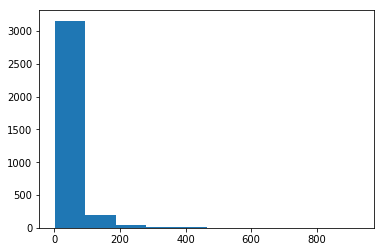

In [211]:
plt.hist(dur.iloc[:,0])#.nlargest(10,'duration')

In [198]:
#indices of experiments when it takes more than ~15 seconds  to cross. 109 rows out of total 3424 removed
out=dur[dur['duration']>150].index



for i in sorted(out,reverse=True):
    del X[i]
    del o1[i]
    del o2[i]
    del o3[i]
    del dist[i]
    del y[i]

In [200]:
# converting list to array
X=np.array(X)
o1=np.array(o1)
o2=np.array(o2)
o3=np.array(o3)
dist=np.array(dist)
y=np.array(y)

In [201]:
Xpadded = pad_sequences(X, dtype='float32')       #padding sequences to have same length by adding 0s
o1padded = pad_sequences(o1,dtype='float32')
o2padded = pad_sequences(o2,dtype='float32')
o3padded = pad_sequences(o3,dtype='float32')
distpadded = pad_sequences(dist,dtype='float32')
ypadded = pad_sequences(y, padding='post',dtype='float32')

In [ ]:
#####not use scaled measures for now
scaler = MinMaxScaler(feature_range=(0, 1))
Xscaled = scaler.fit_transform(Xpadded)

yscaled = scaler.fit_transform(ypadded)

o1scaled = scaler.fit_transform(o1padded)
o2scaled = scaler.fit_transform(o2padded)
o3scaled = scaler.fit_transform(o3padded)
distscaled = scaler.fit_transform(distpadded)

inputseq=[]
for i in range(Xscaled.shape[0]):
    mrg_input=np.transpose(np.vstack((Xscaled[i],o1scaled[i],o2scaled[i],o3scaled[i],distscaled[i])))
    inputseq.append(mrg_input)
    

inputseq=np.array(inputseq)

In [249]:
#ypadded=yscaled

In [236]:
#covedrting to an array shaped: samples * n_steps * features
inputseq=[]
for i in range(Xpadded.shape[0]):
    mrg_input=np.transpose(np.vstack((Xpadded[i],o1padded[i],o2padded[i],o3padded[i],distpadded[i])))
    inputseq.append(mrg_input)
    

inputseq=np.array(inputseq)


In [237]:
#check if data is float:
ypadded.dtype
inputseq.dtype

dtype('float32')

In [247]:




# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = inputseq.shape[2]
n_steps_in=inputseq.shape[1]
n_steps_out=ypadded.shape[1]


In [250]:
# seperate validation data and test set
import random
tst=0.2
val=0.2
tstsize = int(np.floor(len(inputseq) * tst))
valsize = int(np.floor(len(inputseq) * val))



tstlabel=[]
for i in range(tstsize):
    temp = random.randint(0,inputseq.shape[0]+1)
    tstlabel.append(temp)

Xtest=inputseq[tstlabel]
ytest=ypadded[tstlabel]



trnlabel=[i for i in range(inputseq.shape[0]) if i not in tstlabel]
trnsize=len(trnlabel)

Xtrain=inputseq[trnlabel]
ytrain=ypadded[trnlabel]



vallabel=[]
for i in range(valsize):
    temp = trnlabel[random.randint(0,trnsize+1)]
    vallabel.append(temp)

Xval=inputseq[vallabel]
yval=ypadded[vallabel]

trainlabel=[i for i in range(Xtrain.shape[0]) if i not in [vallabel]]
Xtrain=Xtrain[trainlabel]
ytrain=ytrain[trainlabel]

In [ ]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
history=model.fit(Xtrain, ytrain,
                  epochs=200, verbose=1,batch_size=72,
                  validation_data=(Xval, yval))
                  

Train on 2713 samples, validate on 661 samples
Epoch 1/200
2713/2713 [==============================] - 4s 2ms/step - loss: 0.1419 - val_loss: 0.1167
Epoch 2/200
2713/2713 [==============================] - 2s 921us/step - loss: 23819.2963 - val_loss: 0.0958
Epoch 3/200
2713/2713 [==============================] - 3s 926us/step - loss: 0.0896 - val_loss: 0.0708
Epoch 4/200
2713/2713 [==============================] - 3s 930us/step - loss: 0.0695 - val_loss: 0.0595
Epoch 5/200
2713/2713 [==============================] - 3s 923us/step - loss: 0.0588 - val_loss: 0.0530
Epoch 6/200
2713/2713 [==============================] - 3s 1ms/step - loss: 0.0552 - val_loss: 0.0512
Epoch 7/200
2713/2713 [==============================] - 3s 933us/step - loss: 0.0541 - val_loss: 0.0504
Epoch 8/200
2713/2713 [==============================] - 3s 927us/step - loss: 0.0535 - val_loss: 0.0501
Epoch 9/200
2713/2713 [==============================] - 3s 927us/step - loss: 0.0532 - val_loss: 0.0499
Epoch 10

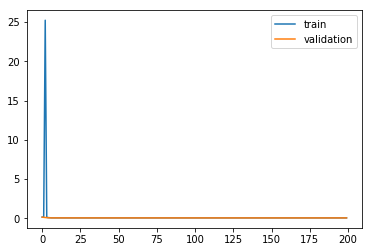

In [271]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
#pyplot.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# make a prediction
yhat = model.predict(Xval)